In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import time



In [31]:
text = """
To be, or not to be, that is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of outrageous fortune,
Or to take Arms against a Sea of troubles...
"""

In [32]:
chars = sorted(list(set(text)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}
n_chars = len(chars)


In [33]:
class TextDataset(Dataset):
    def __init__(self, text, sequence_length=50):
        self.sequence_length = sequence_length
        self.text = text
        self.total_sequences = len(text) - sequence_length

    def __len__(self):
        return self.total_sequences

    def __getitem__(self, idx):
        sequence = self.text[idx:idx + self.sequence_length]
        target = self.text[idx + 1:idx + self.sequence_length + 1]

        x = torch.tensor([char_to_idx[ch] for ch in sequence], dtype=torch.long)
        y = torch.tensor([char_to_idx[ch] for ch in target], dtype=torch.long)

        return x, y


In [34]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        x = F.one_hot(x, num_classes=n_chars).float()
        output, hidden = self.rnn(x, hidden)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return


In [35]:
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (x, y) in enumerate(dataloader):
            hidden = model.init_hidden(x.size(0))

            output, hidden = model(x, hidden)
            loss = criterion(output.view(-1, n_chars), y.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}')



In [36]:
def generate_text(model, seed_text, length=100, temperature=0.8):
    model.eval()
    current_text = seed_text
    hidden = model.init_hidden(1)

    with torch.no_grad():
        for _ in range(length):
            x = torch.tensor([char_to_idx[ch] for ch in current_text[-50:]], dtype=torch.long).unsqueeze(0)
            output, hidden = model(x, hidden)
            probs = F.softmax(output[0, -1] / temperature, dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            current_text += idx_to_char[next_char_idx]

    return current_text




In [37]:
sequence_length = 50
hidden_size = 128
batch_size = 32

dataset = TextDataset(text, sequence_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = SimpleRNN(n_chars, hidden_size, n_chars)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


train_model(model, dataloader, criterion, optimizer, epochs=10)




Epoch 1, Loss: 3.1146
Epoch 2, Loss: 2.6501
Epoch 3, Loss: 2.1989
Epoch 4, Loss: 1.7395
Epoch 5, Loss: 1.3030
Epoch 6, Loss: 0.9381
Epoch 7, Loss: 0.6508
Epoch 8, Loss: 0.4429
Epoch 9, Loss: 0.3085
Epoch 10, Loss: 0.2252


In [38]:
seed = "To be, or not to be"
try:

    os.system('clear')


    temperature = np.random.uniform(0.5, 1.2)
    generated_text = generate_text(model, seed, length=200, temperature=temperature)

    print(f"Temperature: {temperature:.2f}")
    print(f"Generated text:\n{generated_text}")


    time.sleep(2)

except KeyboardInterrupt:
    print("\nStopping text generation...")

Temperature: 0.57
Generated text:
To be, or not to be, that is the mind to suffer
The slings and arrows of outrageous fortune,
Or to take Arms against a Sea of trageous fortune,
Or to take Arms against o blis Se, anethermind to suffer
The slings and arr


# Implementation of LSTMs

For simplicity, we will **generate** a sine wave dataset.

In [39]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

sequence_length = 50
num_epochs = 100
learning_rate = 0.001
input_size = 1
hidden_size = 128
num_layers = 2
output_size = 1

time_steps = np.linspace(0, 100, 1000)
data = np.sin(time_steps)

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        xs.append(data[i:i+sequence_length])
        ys.append(data[i+sequence_length])
    return np.array(xs), np.array(ys)

X, y = create_sequences(data, sequence_length)
X = torch.from_numpy(X).float().unsqueeze(-1)  # (batch_size, seq_length, input_size)
y = torch.from_numpy(y).float().unsqueeze(-1)  # (batch_size, output_size)

# Split into training and testing
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]


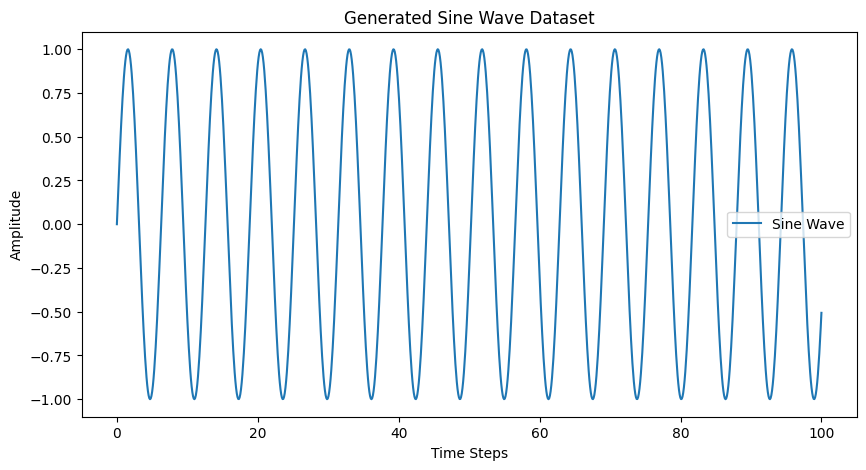

In [40]:
# Plot the generated sine wave dataset
plt.figure(figsize=(10, 5))
plt.plot(time_steps, data, label='Sine Wave')
plt.title('Generated Sine Wave Dataset')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Model Definition

In [41]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
# MSE - mean square error
# MAE - mean absolute error
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [42]:
# Training the model
for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X)
    optimizer.zero_grad()
    loss = criterion(outputs, train_y)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.2227
Epoch [20/100], Loss: 0.0055
Epoch [30/100], Loss: 0.0022
Epoch [40/100], Loss: 0.0008
Epoch [50/100], Loss: 0.0004
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


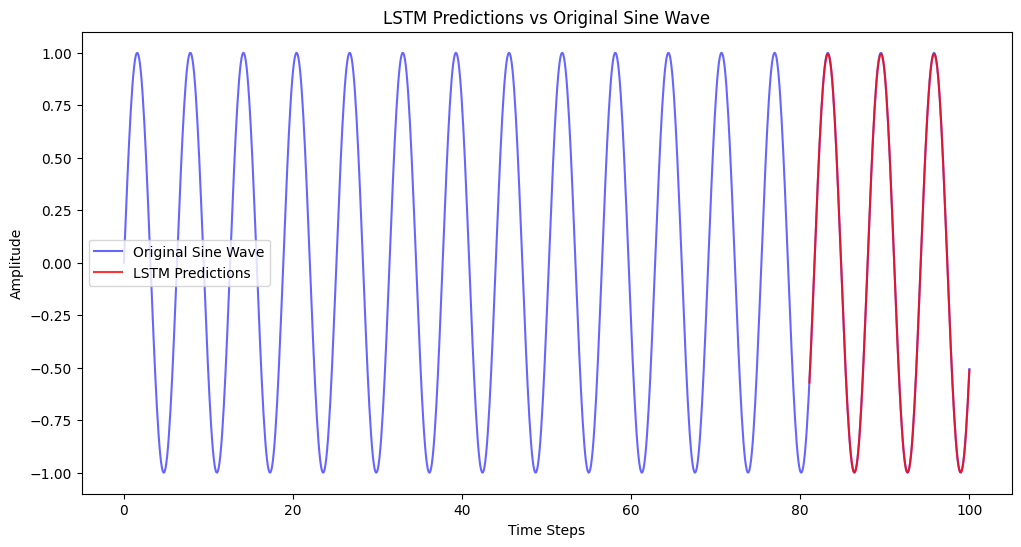

In [43]:
# Plotting the dataset (sine wave) and LSTM predictions
plt.figure(figsize=(12, 6))

# Plot the actual sine wave (full dataset)
plt.plot(time_steps, data, label='Original Sine Wave', color='blue', alpha=0.6)

# Plot LSTM predictions (only for test data)
test_predict = model(test_X).detach().numpy()  # Get model predictions on test set
test_y_np = test_y.numpy()

# Shift predictions to align with the corresponding time steps in the plot
plt.plot(time_steps[-test_size:], test_predict, label='LSTM Predictions', color='red', alpha=0.8)

# Add labels and title
plt.title('LSTM Predictions vs Original Sine Wave')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()

# Show the plot
plt.show()